# image clustering

Quelle: https://towardsdatascience.com/how-to-cluster-images-based-on-visual-similarity-cd6e7209fe34

In [1]:
# imports

# for loading/processing the images
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

In [2]:
# models
from keras.applications.vgg16 import VGG16
from keras.models import Model

In [3]:
# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [4]:
# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

In [5]:
######## Loading the data #########
# I have stored all images into one folder. The images are named with the IDs
path = r"E:\InformationRetrieval\data_new\png" 

# change the working directory to the path where the images are located
os.chdir(path)

# this list holds all the images as files
images = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
    #loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'):
            # adds only image files to the images list
            images.append(file.name)


In [6]:
# Code to extract the feature vectors from a prelearned VGG16 modell
model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img)
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3)
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [7]:
# Now we can use this feature_extraction function to extract the features from all of the images and store the features in a dictionary with filename as the keys.

data = {}
p = r"E:\InformationRetrieval\data_new\png\images_features.pkl"

# loop through each image in the dataset
for image in images:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(image,model)
        data[image] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p, 'wb') as file:
            pickle.dump(data,file)


# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))
print(feat.shape)



C:\Users\grego\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\Image.py:973: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


(23840, 1, 4096)


In [8]:
# reshape so that there are 980 samples of 4096 vectors
feat = feat.reshape(-1,4096)
print(feat.shape)

(23840, 4096)


In [139]:
####### Dimensionality Reduction (PCA) ############

# n_components kann getunet werden 100?
pca = PCA(n_components=10, random_state=22)
pca.fit(feat)
x = pca.transform(feat)


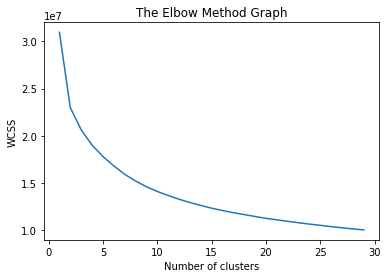

In [55]:
#3 Using the elbow method to find out the optimal number of #clusters. 
#KMeans class from the sklearn library. 
from sklearn.cluster import KMeans
wcss=[]
#this loop will fit the k-means algorithm to our data and 
#second we will compute the within cluster sum of squares and #appended to our wcss list.
for i in range(1,30): 
     kmeans = KMeans(n_clusters=i, init ='k-means++', max_iter=300,  n_init=10,random_state=22 )
#i above is between 1-10 numbers. init parameter is the random #initialization method  
#we select kmeans++ method. max_iter parameter the maximum number of iterations there can be to 
#find the final clusters when the K-meands algorithm is running. we #enter the default value of 300
#the next parameter is n_init which is the number of times the #K_means algorithm will be run with
#different initial centroid.
     kmeans.fit(x)
#kmeans algorithm fits to the X dataset
     wcss.append(kmeans.inertia_)
#kmeans inertia_ attribute is:  Sum of squared distances of samples #to their closest cluster center.
#4.Plot the elbow graph
plt.plot(range(1,30),wcss)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [206]:
######## KMeans clustering #############
# Anzahl Clusters
n_cl = 14
kmeans = KMeans(n_clusters=n_cl, n_jobs=-1, random_state=22)
kmeans.fit(x)

C:\Users\grego\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


KMeans(n_clusters=30, n_jobs=-1, random_state=22)

In [207]:

# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [208]:
# create directionary to store the results 
# Directory
directory = str(n_cl) + "_clusters_10d"

# Parent Directory path
parent_dir = "E:/InformationRetrieval/results_clustering_new"

# Path
path = os.path.join(parent_dir, directory)

os.mkdir(path)
print("Directory '% s' created" % directory)

Directory '30_clusters_100d' created


In [209]:
# tsv file for the ids and corresponding clusters -> needed for indexing 
#Ergebnisfile(.csv) nur mit namen der Bilder und zugehörigem Cluster erstellen?
data =[]
for y in range(0, len(groups)):
    for id in groups[y]:
        data.append([id.replace('.png', ''), str(y)])

import pandas as pd

df = pd.DataFrame(data = data, columns=["id", "cluster"])

file_name = path + "/image_cluster" + str(n_cl) +  ".tsv"
df.to_csv(file_name, sep="\t", index=False)
    

In [49]:
# copy images into dictionarys each cluster to get a overview of the content of the clusters 
## In Zukunft nur noch ca. 50 beispiel bilder pro cluster in ordner verteilen um das verfahren bewerten zu können.
## Die eigentliche Zuordung sollte in einer csv datei gespeichert werden

import shutil
#
parent_dir = path
for group in groups:
    dir = 'group' + str(group)
    path_2 = os.path.join(parent_dir, dir)
    os.mkdir(path_2)
    #print(group)
    for num, i in enumerate(groups[group]):
        #print(i)
        source = 'E:/InformationRetrieval/png/' + i
        dest = path_2 + '/' + i
        shutil.copyfile(source, dest)
        # 50 example images per cluster
        if(num == 49):
            break

### Visualization of the Distributions ###

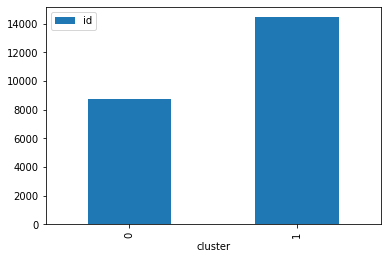

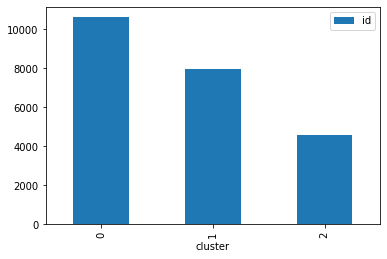

In [53]:
# visualization of the distribution of clusters
import pandas as pd

number_of_cluster = ["2","3"]

for number in number_of_cluster:

    df_for_visualization = pd.read_csv('E:/InformationRetrieval/results_clustering/' + number + '_clusters/image_cluster' + number + '.tsv', sep='\t')

    df_for_visualization.groupby('cluster').count().plot.bar().figure.savefig('E:/InformationRetrieval/results_clustering/' + number + '_clusters/distr' + number + 'cluster.png')



In [25]:
#df_for_visualization.groupby('cluster').count()

,id
cluster,
0,2196
1,3742
2,2390
3,3707
4,4025
5,7112


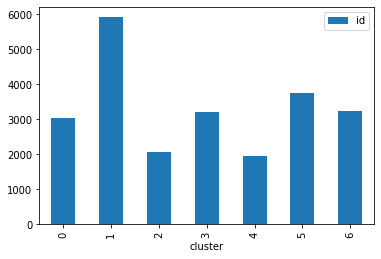

In [31]:
#df_for_visualization.groupby('cluster').count().plot.bar().figure.savefig('E:/InformationRetrieval/results_clustering/7_clusters/distr7cluster2.png')

### Scatter Plots for kmeans ###

In [59]:
#Import required module
from sklearn.cluster import KMeans
 
#Initialize the class object
kmeans = KMeans(n_clusters= 14)
 
#predict the labels of clusters.
label = kmeans.fit_predict(x)
 
print(label)

[11  2  9 ...  4  4 13]


In [60]:
pca = PCA(n_components=2, random_state=22)
pca.fit(x)
y = pca.transform(x)


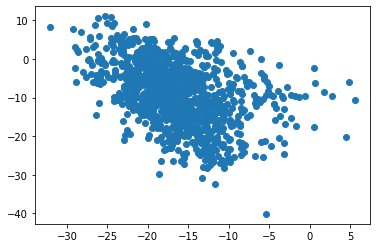

In [168]:
import matplotlib.pyplot as plt
 
#filter rows of original data
filtered_label0 = y[label ==9]
 
#plotting the results
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1])
plt.show()

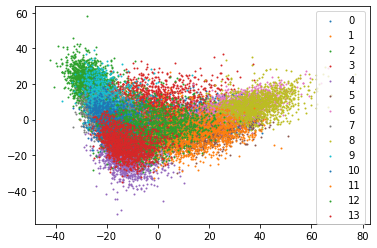

In [61]:
#Getting unique labels
 
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(y[label == i , 0] , y[label == i , 1] , label = i, s = 1)
plt.legend()
plt.show()

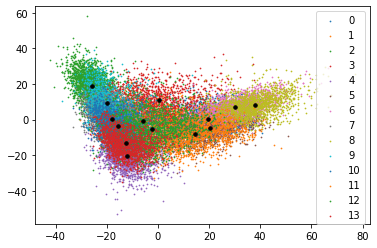

In [62]:
#Getting the Centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(y[label == i , 0] , y[label == i , 1] , label = i, s = 0.5)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 12, color = 'black')
plt.legend()
plt.show()